Data set provided by University of Tübingen, Germany, Dept. of Computer Engineering (Prof. Rosenstiel) and Institute of Medical Psychology and Behavioral Neurobiology (Niels Birbaumer), and 
Max-Planck-Institute for Biological Cybernetics, Tübingen, Germany (Bernhard Schölkopf), and 
Universität Bonn, Germany, Dept. of Epileptology (Prof. Elger)

Experiment

During the BCI experiment, a subject had to perform imagined movements of either the left small finger or the tongue. The time series of the electrical brain activity was picked up during these trials using a 8x8 ECoG platinum electrode grid which was placed on the contralateral (right) motor cortex. The grid was assumed to cover the right motor cortex completely, but due to its size (approx. 8x8cm) it partly covered also surrounding cortex areas. All recordings were performed with a sampling rate of 1000Hz. After amplification the recorded potentials were stored as microvolt values. Every trial consisted of either an imagined tongue or an imagined finger movement and was recorded for 3 seconds duration. To avoid visually evoked potentials being reflected by the data, the recording intervals started 0.5 seconds after the visual cue had ended.

The training data consists of two parts:

Part 1: the brain activity during 278 trials. This part is stored in a 3D matrix named X using the following format: [trials x electrode channels x samples of time series].
Part 2: the labels of the 278 trials. This part is stored as a vector of -1 / 1 values named Y.

The test data has the same form as the training data but with no label.



In [1]:
%matplotlib inline

from __future__ import division

import numpy as np
import scipy as sp
from scipy.io import loadmat
from matplotlib import pyplot as plt
import matplotlib as mpl

from wyrm import processing as proc
from wyrm.types import Data
from wyrm import plot
from wyrm.io import load_bcicomp3_ds1
plot.beautify()

In [2]:
DATA_DIR = 'C:\Users\Eniola\Documents\Educational\Research\data\BCI_COMP_III_Tuebingen'
TRUE_LABELS = 'C:\Users\Eniola\Documents\Educational\Research\data\BCI_COMP_III_Tuebingen\\true_labels.txt'

In [3]:
# load test and training data
train, test = load_bcicomp3_ds1(DATA_DIR)

test.class_names = ['pinky', 'tongue']

# load true labels
true_labels = np.loadtxt(TRUE_LABELS).astype('int')


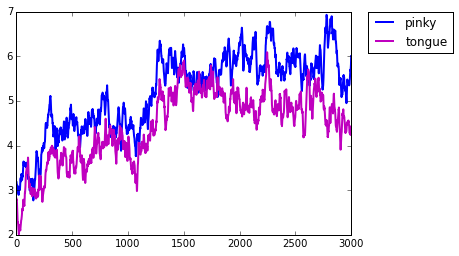

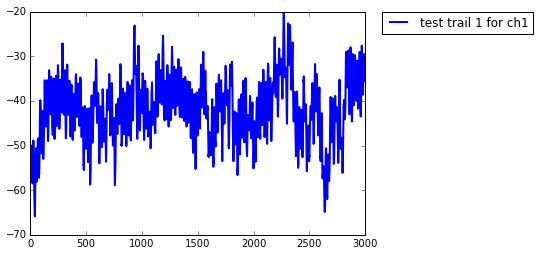

In [4]:
from wyrm.processing import calculate_classwise_average

intv=3000

#We want to visualize what the data look like, hence we found the average of each class
avg_epo_train = calculate_classwise_average(train)

plt.figure(1)

#This is plotting the graph of the first class
plt.plot(proc.select_ival(train, [0, intv]).axes[1], #selecting time interval to plt
          proc.select_ival(proc.select_classes(proc.select_channels(avg_epo_train, ['0']), [0]), 
                           [0, intv]).data[0], label='pinky') 

#This is plotting the graph of the second class
plt.plot(proc.select_ival(train, [0, intv]).axes[1], #selecting time interval to plt
          proc.select_ival(proc.select_classes(proc.select_channels(avg_epo_train, ['0']), [1]), 
                           [0, intv]).data[0], label='tongue')

# plt.plot(proc.select_ival(train, [0, intv]).axes[1], #selecting time interval to plt
#           proc.select_ival(proc.select_classes(proc.select_channels(train, ['0']), [1]), 
#                            [0, intv]).data[0])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure(2)

#plottings the test data from two different trails on the same channel
plt.plot(proc.select_ival(test, [0, intv]).axes[1], proc.select_channels(test, ['0']).data[0,:,:], label='test trail 1 for ch1') 

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

It can be observed from the plots above that there are offsets caused by the presense of dc components. Therefore a high pass filter will be applied to remove such. It can also be observed that noise in the first plot has been reduced drastically due to the classwise averaging compare to the second individual trial plot which contain high frequency niose probably due to AC nosie.
Also, the magnitude or the variance of the individual trial is much greater than the classwise average which may necessitate channel scaling (see Wikipedia: feature scaling)

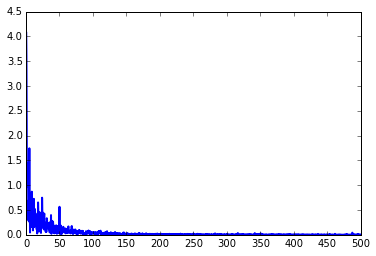

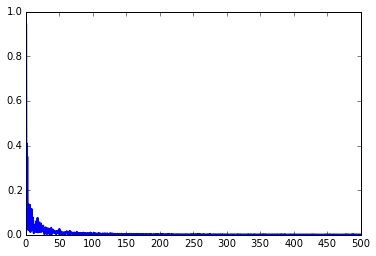

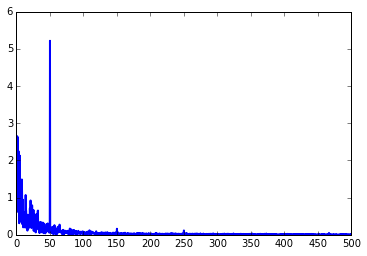

In [5]:
plt.figure(1)
#spectrum plot of a trial 1, channel 1 in training data
plt.plot(proc.spectrum(train).axes[1], proc.spectrum(proc.select_classes(proc.select_channels(train, ['0']), [0])).data[0])

plt.locator_params(nbins=20, axis='x')

plt.figure(2)
#spectrum plot of the averaged training data class pinky, channel 1
plt.plot(proc.spectrum(avg_epo_train).axes[1], proc.spectrum(proc.select_classes(proc.select_channels(avg_epo_train, ['0']), [0])).data[0])

plt.locator_params(nbins=20, axis='x')

plt.figure(3)
#spectrum plot of a trial 1, channel 1 in test data
plt.plot(proc.spectrum(test).axes[1], proc.spectrum(proc.select_classes(proc.select_channels(test, ['0']), [0])).data[0])

plt.locator_params(nbins=20, axis='x')

We observer the effect of AC noise at 50Hz (voltage frequency in Germany is 50Hz). Also we can observe that the noise is more pronounced in the test data (the last plot). Therefore we will need to do a low pass filtering to remove the 50Hz noise.

In [6]:
#HPF

fs_n = train.fs/2
b, a = proc.signal.butter(5, [9/fs_n], btype='high')
filter_train = proc.filtfilt(train, b, a)

We have used a Butterworth filter for this BCI experiment for its maximally flat frequency response in the passband. But we need to investigate what happens at the stop band with respect to the frequency resolution of the FFT: we do not what it to cut into the frequency band of interest (mu:8-12 and beta:13-28). Since every trial is 3s long, the window length is 3s, therefore the frequency resolution will be 1/3 Hz. 

The frequency band of interest will be used to generate the feature vectors needed for classification as a result of the ERD and ERS coming as a consequence of motor imagination by the subject.

The filter order selected conforms to what is most common used in literatures. 

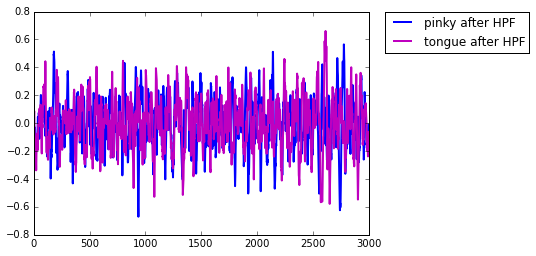

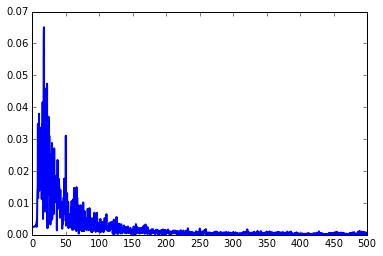

In [7]:

#We want to visualize what the data look like, hence we found the average of each class
avg_epo_train_HPF = calculate_classwise_average(filter_train)

plt.figure(1)
#This is plotting the graph of the first class
plt.plot(proc.select_ival(avg_epo_train_HPF, [0, intv]).axes[1], #selecting time interval to plt
          proc.select_ival(proc.select_classes(proc.select_channels(avg_epo_train_HPF, ['0']), [0]), 
                           [0, intv]).data[0], label='pinky after HPF') 

#This is plotting the graph of the second class
plt.plot(proc.select_ival(avg_epo_train_HPF, [0, intv]).axes[1], #selecting time interval to plt
          proc.select_ival(proc.select_classes(proc.select_channels(avg_epo_train_HPF, ['0']), [1]), 
                           [0, intv]).data[0], label='tongue after HPF')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure(2)
#spectrum plot of the averaged training data class pinky, channel 1
plt.plot(proc.spectrum(avg_epo_train_HPF).axes[1], proc.spectrum(proc.select_classes(proc.select_channels(avg_epo_train_HPF, ['0']), [0])).data[0])

plt.locator_params(nbins=20, axis='x')

In [8]:
#LPF

fs_n = train.fs/2
b, a = proc.signal.butter(5, [13/fs_n], btype='low')
filter_train = proc.filtfilt(filter_train, b, a)

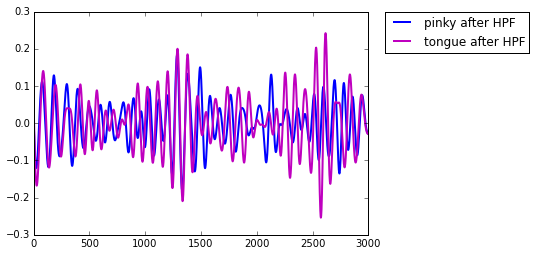

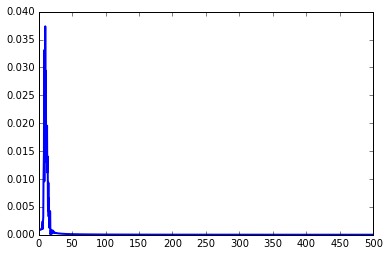

In [9]:
#We want to visualize what the data look like, hence we found the average of each class
avg_epo_train_HPF = calculate_classwise_average(filter_train)

plt.figure(1)
#This is plotting the graph of the first class
plt.plot(proc.select_ival(avg_epo_train_HPF, [0, intv]).axes[1], #selecting time interval to plt
          proc.select_ival(proc.select_classes(proc.select_channels(avg_epo_train_HPF, ['0']), [0]), 
                           [0, intv]).data[0], label='pinky after HPF') 

#This is plotting the graph of the second class
plt.plot(proc.select_ival(avg_epo_train_HPF, [0, intv]).axes[1], #selecting time interval to plt
          proc.select_ival(proc.select_classes(proc.select_channels(avg_epo_train_HPF, ['0']), [1]), 
                           [0, intv]).data[0], label='tongue after HPF')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure(2)
#spectrum plot of the averaged training data class pinky, channel 1
plt.plot(proc.spectrum(avg_epo_train_HPF).axes[1], proc.spectrum(proc.select_classes(proc.select_channels(avg_epo_train_HPF, ['0']), [0])).data[0])

plt.locator_params(nbins=20, axis='x')

In [10]:
#subsample: this step is taken soley to reduce the memory overhead and improve computation time

filter_train = proc.subsample(filter_train, 50)

filt, pattern, _ = proc.calculate_csp(filter_train)

filter_train = proc.apply_csp(filter_train, filt)

fv_train = proc.variance(filter_train)

fv_train = proc.logarithm(fv_train)


In [11]:
# Test Data

#HPF

fs_n = test.fs/2
b, a = proc.signal.butter(5, [9/fs_n], btype='high')
filter_test = proc.filtfilt(test, b, a)

#LPF

fs_n = test.fs/2
b, a = proc.signal.butter(5, [13/fs_n], btype='low')
filter_test = proc.filtfilt(filter_test, b, a)

#subsample: this step is taken soley to reduce the memory overhead and improve computation time

filter_test = proc.subsample(filter_test, 50)

#filt, pattern, _ = proc.calculate_csp(filter_test)

filter_test = proc.apply_csp(filter_test, filt)

fv_test = proc.variance(filter_test)

fv_test = proc.logarithm(fv_test)


In [14]:
cfy = proc.lda_train(fv_train)
result = proc.lda_apply(fv_test, cfy)
import numpy as np
result = np.sign(result)
print "Classification Accuracy: {}".format((result == true_labels).sum()/len(true_labels))

Classification Accuracy: 0.94
